In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

sys.path.append(os.path.join(os.getenv("HOME"), "gpuaffman_networks/"))
from genetics import tasks, ragged_task_evolution

In [14]:
plt_save_dir = "/home/trevor/boolean_network_data/plots_and_misc_material"

In [3]:
input_states = tasks.make_2_bit_input_state(8)

In [4]:
data_dir_no_noise = "boolean_network_data/and_evolution_results/no_noise_2023-03-13-20-40-28"
data_no_noise = np.load(os.path.join(os.getenv("HOME"), data_dir_no_noise, "batch_1.npz"))
nn_best_functions = data_no_noise["functions"]
nn_best_connectivity = data_no_noise["connectivity"]
nn_best_used_connectivity = data_no_noise["used_connectivity"]
nn_batched_input_state = np.broadcast_to(np.expand_dims(np.expand_dims(input_states, 1), 1), (input_states.shape[0], nn_best_functions.shape[0], 1, input_states.shape[-1]))
errors_nn = ragged_task_evolution.evaluate_populations(nn_batched_input_state, 1, np.expand_dims(nn_best_functions, 1), np.expand_dims(nn_best_connectivity, 1), np.expand_dims(nn_best_used_connectivity, 1), 10, 0, tasks.evaluate_and_task)
zero_idx = np.where(np.squeeze(errors_nn) == 0)
perfs_nn = np.squeeze(zero_idx)
nn_best_functions = nn_best_functions[perfs_nn]
nn_best_connectivity = nn_best_connectivity[perfs_nn]
nn_best_used_connectivity = nn_best_used_connectivity[perfs_nn]


In [5]:
data_dir_noise = "boolean_network_data/and_evolution_results/2023-03-11-15-43-20"
data_noise = np.load(os.path.join(os.getenv("HOME"), data_dir_noise, "batch_1.npz"))
use_best = 50
sorted_order = np.argsort(data_noise["errors"])
best_functions = data_noise["functions"][sorted_order][:use_best]
best_connectivity = data_noise["connectivity"][sorted_order][:use_best]
best_used_connectivity = data_noise["used_connectivity"][sorted_order][:use_best]
n_batched_input_state = np.broadcast_to(np.expand_dims(np.expand_dims(input_states, 1), 1), (input_states.shape[0], best_functions.shape[0], 1, input_states.shape[-1]))
errors_n = ragged_task_evolution.evaluate_populations(n_batched_input_state, 1, np.expand_dims(best_functions, 1), np.expand_dims(best_connectivity, 1), np.expand_dims(best_used_connectivity, 1), 10, 0, tasks.evaluate_and_task)
zero_idx = np.where(np.squeeze(errors_n) == 0)
perfs_n = np.squeeze(zero_idx)
best_functions = best_functions[perfs_n]
best_connectivity = best_connectivity[perfs_n]
best_used_connectivity = best_used_connectivity[perfs_n]

In [6]:

N = nn_best_functions.shape[1]

In [7]:
all_mutations = []
for i in range(best_functions.shape[1]):
    for j in range(best_functions.shape[2]):
        mutation = np.zeros_like(best_functions[0])
        mutation[i, j] = True
        all_mutations.append(mutation)
all_mutations = np.array(all_mutations)

In [8]:
all_conn_mutations = []
for i in range(best_used_connectivity.shape[1]):
    for j in range(best_used_connectivity.shape[2]):
        mutation = np.zeros_like(best_used_connectivity[0])
        mutation[i, j] = True
        all_conn_mutations.append(mutation)
all_conn_mutations = np.array(all_conn_mutations)

In [9]:
def eval_function_mutation(input_states, mutations, functions, connectivity, used_connectivity):
    mutated_functions = np.bitwise_xor(np.expand_dims(mutations, 1), functions)
    connectivity = np.broadcast_to(np.expand_dims(connectivity, 0), (*mutated_functions.shape[:-1], connectivity.shape[-1]))
    used_connectivity = np.broadcast_to(np.expand_dims(used_connectivity, 0), (*mutated_functions.shape[:-1], used_connectivity.shape[-1]))
    batched_input_states = np.expand_dims(np.expand_dims(input_states, 1), 1)
    batched_input_states = np.broadcast_to(batched_input_states, (batched_input_states.shape[0], *connectivity.shape[:-2], batched_input_states.shape[-1]))
    perf = ragged_task_evolution.evaluate_populations(batched_input_states, 1, mutated_functions, connectivity, used_connectivity, 10,0, tasks.evaluate_and_task)
    return perf

perf_no_noise = eval_function_mutation(input_states, all_mutations, nn_best_functions, nn_best_connectivity, nn_best_used_connectivity)
perf_noise = eval_function_mutation(input_states, all_mutations, best_functions, best_connectivity, best_used_connectivity)
n_lethal_noise = np.count_nonzero(perf_noise, 0)
n_lethal_no_noise = np.count_nonzero(perf_no_noise, 0)

In [10]:
def eval_conn_mutation(input_states, mutations, functions, connectivity, used_connectivity):
    mutated_used_conn = np.bitwise_xor(np.expand_dims(mutations, 1), used_connectivity)
    connectivity = np.broadcast_to(np.expand_dims(connectivity, 0), (*mutated_used_conn.shape[:-1], connectivity.shape[-1]))
    functions = np.broadcast_to(np.expand_dims(functions, 0), (*mutated_used_conn.shape[:-1], functions.shape[-1]))
    batched_input_states = np.expand_dims(np.expand_dims(input_states, 1), 1)
    batched_input_states = np.broadcast_to(batched_input_states, (batched_input_states.shape[0], *functions.shape[:-2], batched_input_states.shape[-1]))
    perf = ragged_task_evolution.evaluate_populations(batched_input_states, 1, functions, connectivity, mutated_used_conn, 10,0, tasks.evaluate_and_task)
    return perf

perf_c_no_noise = eval_conn_mutation(input_states, all_conn_mutations, nn_best_functions, nn_best_connectivity, nn_best_used_connectivity)
perf_c_noise = eval_conn_mutation(input_states, all_conn_mutations, best_functions, best_connectivity, best_used_connectivity)
n_lethal_c_noise = np.count_nonzero(perf_c_noise, 0)
n_lethal_no_c_noise = np.count_nonzero(perf_c_no_noise, 0)

In [11]:
def make_cdf(data):
    data_sorted = np.sort(data)
    p = 1. * np.arange(len(data)) / (len(data) - 1)
    return data_sorted, p

sorted_lethal_noise, p_lethal_noise = make_cdf(n_lethal_noise)
sorted_lethal_nn, p_lethal_nn = make_cdf(n_lethal_no_noise)

sorted_lethal_c_noise, p_lethal_c_noise = make_cdf(n_lethal_c_noise)
sorted_lethal_no_c_noise, p_lethal_no_c_noise = make_cdf(n_lethal_no_c_noise)

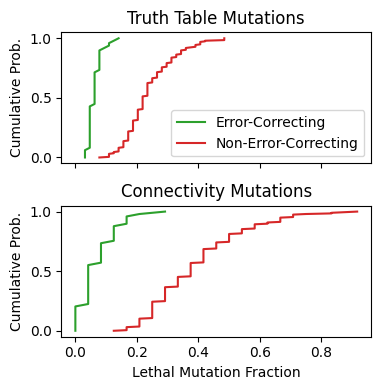

In [15]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(4, 4))
axs[0].plot(sorted_lethal_noise/np.shape(all_mutations)[0], p_lethal_noise, color="C2", label="Error-Correcting")
axs[0].plot(sorted_lethal_nn/np.shape(all_mutations)[0], p_lethal_nn, color="C3", label="Non-Error-Correcting")
axs[0].legend()
axs[0].set_ylabel("Cumulative Prob.")
axs[0].set_title("Truth Table Mutations")

axs[1].plot(sorted_lethal_c_noise/np.shape(all_conn_mutations)[0], p_lethal_c_noise, color="C2")
axs[1].plot(sorted_lethal_no_c_noise/np.shape(all_conn_mutations)[0], p_lethal_no_c_noise, color="C3")
axs[1].set_ylabel("Cumulative Prob.")
axs[1].set_xlabel("Lethal Mutation Fraction")
axs[1].set_title("Connectivity Mutations")
fig.tight_layout()

fig.savefig(os.path.join(plt_save_dir, "mutation_survival.svg"))